# Meta-Sampling: Estratégia de seleção de instâncias baseada em meta-aprendizado

## Imports

In [47]:
import warnings 

import pandas as pd 
import numpy as np

## Elaboração de meta-base 

In [4]:
DATA_DIR = '../../metabase/'

Metafeatures (não supervisionadas) que serão utilizadas para o método:

In [5]:
meta_features = ['attr_conc.mean', 'attr_conc.sd', 'attr_ent.mean', 'attr_ent.sd', 'attr_to_inst', 'cat_to_num', 'cohesiveness.mean', 
                 'cohesiveness.sd', 'cor.mean', 'cor.sd', 'cov.mean', 'cov.sd', 'eigenvalues.mean', 'eigenvalues.sd', 'g_mean.mean', 'g_mean.sd',
                 'h_mean.mean', 'h_mean.sd', 'inst_to_attr', 'iq_range.mean', 'iq_range.sd', 'kurtosis.mean', 'kurtosis.sd', 'mad.mean', 'mad.sd'
                 , 'max.mean', 'max.sd', 'mean.mean', 'mean.sd', 'median.mean', 'median.sd', 'min.mean', 'min.sd', 'nr_attr', 'nr_bin', 'nr_cat',
                 'nr_cor_attr', 'nr_inst', 'nr_norm', 'nr_num', 'nr_outliers', 'num_to_cat', 'one_itemset.mean', 'one_itemset.sd', 'range.mean', 
                 'range.sd', 'sd.mean', 'sd.sd', 'skewness.mean', 'skewness.sd', 'sparsity.mean', 'sparsity.sd', 't2', 't3', 't4', 't_mean.mean',
                 't_mean.sd', 'two_itemset.mean', 'two_itemset.sd', 'var.mean', 'var.sd', 'wg_dist.mean', 'wg_dist.sd']

In [6]:
metrics = ['accuracy', 'f1-micro', 'f1-macro', 'f1-weighted']

In [7]:
%%time
import os
import numpy as np
import pandas as pd

csv_files =  [file for file in os.listdir(DATA_DIR) if file.endswith('csv')]
df_list = [pd.read_csv(os.path.join(DATA_DIR, file), index_col=False) for file in csv_files]

CPU times: user 10.2 s, sys: 1.19 s, total: 11.4 s
Wall time: 11.4 s


Juntando dataframes:

In [8]:
columns = ['estimator', 'query-strategy'] + metrics + meta_features 
df = pd.concat(df_list, keys=csv_files)
df = df[columns]
df.index.names=['dataset', 'index']

Adicionando a informação referente à query:

In [9]:
def add_query_index(x):
    x['query_index']=range(len(x))
    return x
df = df.groupby(['dataset','estimator', 'query-strategy'], group_keys=False).apply(add_query_index)

Rotulando qual melhor estratégia para cada tripla `(dataset, estimator, query_index)` com base na acurácia:

In [10]:
meta_base = df.groupby(['dataset','estimator','query_index'], group_keys=True).apply(lambda x: x.loc[x['accuracy'].idxmax()])
meta_base.drop(['estimator', 'query_index'] + metrics, axis=1, inplace=True)

In [11]:
meta_base

query-strategy  \
dataset        estimator              query_index                         
1005_glass.csv DecisionTreeClassifier 0            uncertainty_sampling   
                                      1                 margin_sampling   
                                      2                 margin_sampling   
                                      3                 margin_sampling   
                                      4                entropy_sampling   
...                                                                 ...   
991_car.csv    SVCLinear              95                margin_sampling   
                                      96                margin_sampling   
                                      97                margin_sampling   
                                      98                margin_sampling   
                                      99           uncertainty_sampling   

                                                   attr_conc.mean  \
dataset        estimator              query_index                   
1005_glass.csv DecisionTreeClassifier 0                  0.082414   
                                      1                  0.081938   
                                      2                  0.083475   
                                      3                  0.084567   
                                      4                  0.091017   
...                                                           ...   
991_car.csv    SVCLinear              95                 0.021034   
                                      96                 0.027452   
                                      97                 0.024350   
                                      98                 0.023121   
                                      99                 0.017146   

                                                   attr_conc.sd  \
dataset        estimator              query_index                 
1005_glass.csv DecisionTreeClassifier 0                0.064700   
                                      1                0.061594   
                                      2                0.062401   
                                      3                0.059189   
                                      4                0.066402   
...                                                         ...   
991_car.csv    SVCLinear              95               0.058361   
                                      96               0.070061   
                                      97               0.062404   
                                      98               0.059174   
                                      99               0.044504   

                                                   attr_ent.mean  attr_ent.sd  \
dataset        estimator              query_index                               
1005_glass.csv DecisionTreeClassifier 0                 2.013577     0.628029   
                                      1                 2.010002     0.636588   
                                      2                 2.010450     0.635328   
                                      3                 2.012189     0.632815   
                                      4                 2.015954     0.625010   
...                                                          ...          ...   
991_car.csv    SVCLinear              95                0.847737     0.063479   
                                      96                0.847793     0.063381   
                                      97                0.847837     0.063279   
                                      98                0.847787     0.063222   
                                      99                0.847080     0.063511   

                                                   attr_to_inst  cat_to_num  \
dataset        estimator              query_index                             
1005_glass.csv DecisionTreeClassifier 0                0.058824         0.0   
                    

Fazendo download do arquivo:

In [12]:
meta_base.to_csv('metabase.csv')

## Treinamento de Meta-Modelo

In [28]:
meta_base =  pd.read_csv('metabase.csv', index_col=['dataset', 'estimator', 'query_index'])

Substituindo valores infinitos por `np.nan`

In [29]:
meta_base.replace([np.inf, -np.inf], np.nan, inplace=True)

Separando uma base para teste e o restante para treinamento (LOO)

In [30]:
train_index = meta_base.index.levels[0][:-1]
test_index = meta_base.index.levels[0][-1:]

len(train_index), len(test_index)

(87, 1)

Separando features e rótulos (utilizando apenas o classificador SVM)

In [31]:
train_data = meta_base.loc[train_index].xs("SVC", level='estimator').reset_index()
test_data = meta_base.loc[test_index].xs("SVC", level='estimator').reset_index()

Separando conjuntos em treino e teste

In [32]:
X_train = train_data.drop(columns=['dataset', 'query-strategy', 'query_index'])
y_train = train_data['query-strategy']

X_test = test_data.drop(columns=['dataset', 'query-strategy', 'query_index'])
y_test = test_data['query-strategy']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6508, 63) (6508,)
(100, 63) (100,)


Induzindo modelo

In [33]:
import numpy as np 
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline



clf = Pipeline([
    ('mean_inputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('meta-model', RandomForestClassifier())
])

clf.fit(X_train.values, y_train)

/home/gabrielscn/.local/lib/python3.8/site-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: [41]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Pipeline(steps=[('mean_inputer', SimpleImputer()),
                ('meta-model', RandomForestClassifier())])

In [45]:
import pickle as pkl

with open('meta_model.pkl', 'wb') as f:
    pkl.dump(clf, f)

## Implementando Meta-sampling

Sampling strategy utilizada:

In [51]:
from modAL.batch import uncertainty_batch_sampling
from modAL.disagreement import consensus_entropy_sampling, max_disagreement_sampling, vote_entropy_sampling
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling
from pymfe.mfe import MFE

def meta_sampling(classifier, X_pool, n_instances):
    query_strategies = {
        'consensus_entropy_sampling': consensus_entropy_sampling,
        'entropy_sampling': entropy_sampling,
        'margin_sampling': margin_sampling,
        'max_disagreement_sampling': max_disagreement_sampling,
        'uncertainty_batch_sampling': uncertainty_batch_sampling,
        'uncertainty_sampling': uncertainty_sampling,
        'vote_entropy_sampling': vote_entropy_sampling
    }

    # carregando modelo
    with open('meta_model.pkl', 'rb') as f:
        model = pkl.load(f)

    # extração de metafeatures
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        mfe = MFE(groups='all')
        mfe.fit(X_pool)
        names, mfts = mfe.extract()

    X = [mfts]

    selected_strategy = query_strategies[model.predict(X)[0]]

    return selected_strategy(classifier, X_pool, n_instances=n_instances)

In [39]:
%load_ext autoreload
%autoreload 2

from active_learning import ActiveLearningExperiment


dataset_id = int(test_index[0].split('_')[0])

exp = ActiveLearningExperiment(dataset_id=dataset_id,
                               random_state=42,
                               l_size=5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
from sklearn.svm import SVC
from modAL.uncertainty import uncertainty_sampling


with warnings.catch_warnings():
    warnings.simplefilter('ignore', category= UserWarning)
    scores_meta_sampling = exp.run(estimator=SVC(probability=True),
                                   query_strategy=meta_sampling,
                                   committee_size=3,
                                   batch_size=5)

## Comparando Estratégias

In [95]:
test_metrics = df.groupby(['dataset', 'estimator']).get_group((test_index[0], 'SVC')).reset_index()

In [103]:
metrics_dict = dict()
for strategy, data in test_metrics.groupby('query-strategy'):
    metrics_dict[strategy] = data['accuracy'].values

In [104]:
metrics_dict['meta_sampling'] = scores_meta_sampling

In [135]:
styles = ['.-', '*-', 'v-', 'h-', '^-', 's-', 'x-', 'd-']

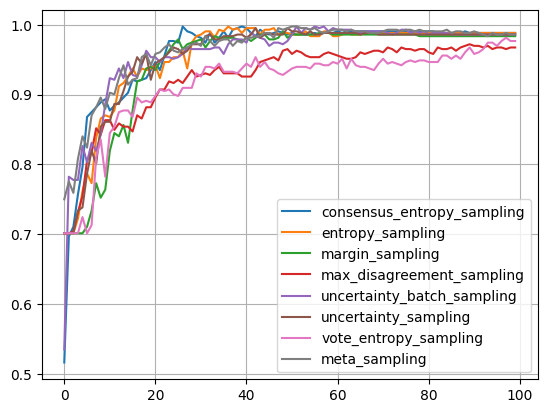

In [142]:
ax = pd.DataFrame(metrics_dict).plot(grid=True, markersize=5)

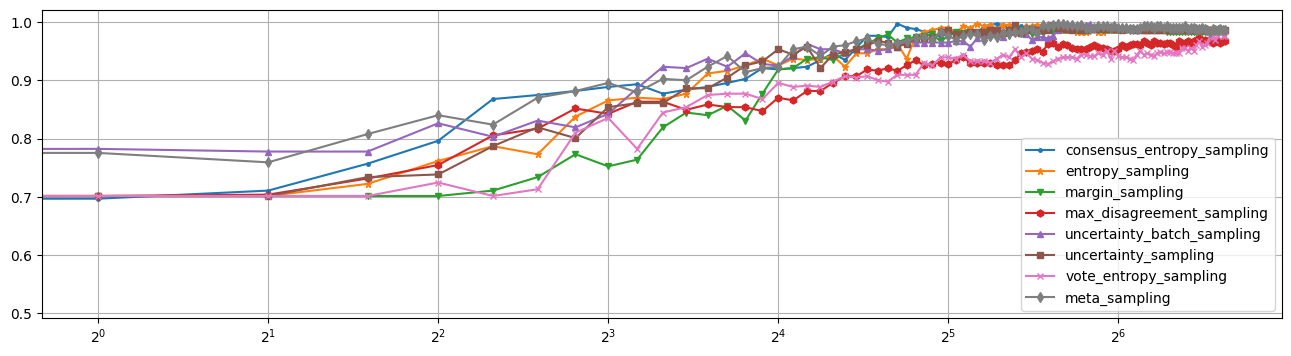

In [145]:
ax = pd.DataFrame(metrics_dict).plot(grid=True, style=styles, markersize=5, figsize=(16,4))
ax.set_xscale('log', base=2)

### Estabelecendo uma estratégia "perfeita"

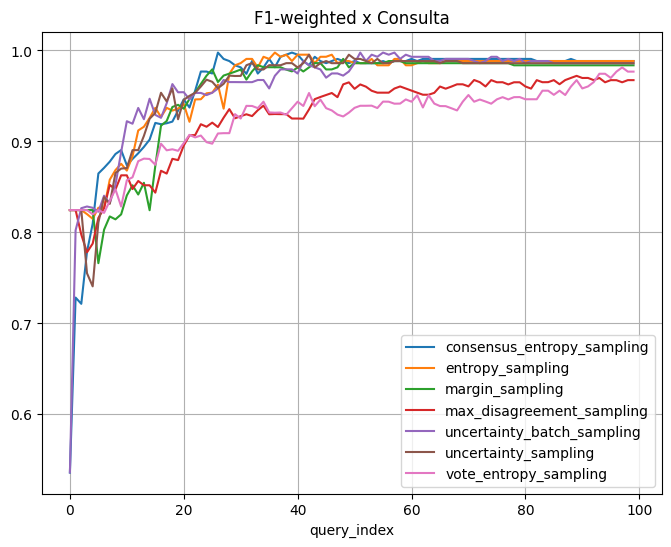

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))

for query_strategy, metrics in test_metrics.groupby('query-strategy'):
    metrics.plot(ax=ax, label=query_strategy, x='query_index', y='f1-weighted', grid=True, title="F1-weighted x Consulta" )

In [26]:
X_train

,attr_conc.mean,attr_conc.sd,attr_ent.mean,attr_ent.sd,attr_to_inst,cat_to_num,cohesiveness.mean,cohesiveness.sd,cor.mean,cor.sd,...,t3,t4,t_mean.mean,t_mean.sd,two_itemset.mean,two_itemset.sd,var.mean,var.sd,wg_dist.mean,wg_dist.sd
0,0.082414,0.064700,2.013577,0.628029,0.058824,0.0,68.776144,8.178187,0.227861,0.182680,...,0.032680,0.555556,11.262624,23.494743,0.351275,0.115866,0.701364,0.765557,0.570600,0.245226
1,0.087557,0.066428,2.014357,0.630069,0.060811,0.0,64.854730,8.345498,0.256375,0.201260,...,0.027027,0.444444,11.271099,23.499820,0.351275,0.116344,0.584469,0.745899,0.595890,0.239361
2,0.083475,0.062401,2.010450,0.635328,0.062937,0.0,63.673077,7.793606,0.227566,0.179406,...,0.034965,0.555556,11.263407,23.500758,0.351275,0.117441,0.717632,0.785717,0.601274,0.249164
3,0.096045,0.073657,2.011386,0.633058,0.065217,0.0,60.163043,8.646054,0.300032,0.214881,...,0.028986,0.444444,11.281622,23.503188,0.351275,0.118416,0.362095,0.448257,0.619745,0.229927
4,0.094061,0.075400,2.015525,0.625474,0.067669,0.0,58.312030,7.998840,0.314686,0.226385,...,0.030075,0.444444,11.282272,23.503986,0.351275,0.116486,0.315198,0.405641,0.635527,0.220325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6503,0.087516,0.115259,0.675641,0.404188,1.565217,0.0,3.461957,0.344776,NaN,NaN,...,0.043478,0.027778,10.002833,49.498684,0.496454,0.176360,581.454150,3480.123397,2.120636,0.132970
6504,0.153923,0.177801,0.666853,0.424402,2.000000,0.0,2.534722,0.264490,NaN,NaN,...,0.055556,0.027778,9.503819,46.652437,0.492958,0.173001,460.515241,2754.496975,2.188125,0.131753
6505,0.145447,0.194345,0.648330,0.452753,2.769231,0.0,1.923077,0.304217,NaN,NaN,...,0.076923,0.027778,3.771235,13.235418,0.484765,0.168950,63.547260,376.529980,2.142825,0.204483
6506,0.278989,0.229971,0.638778,0.469756,4.500000,0.0,1.046875,0.218431,NaN,NaN,...,0.125000,0.027778,3.557500,11.780224,0.481100,0.205757,70.583138,418.914458,2.351588,0.235123


In [27]:
X_train.values.shape

(6508, 63)